## Multiclass Support Vector Machine exercise

在这个练习：
- 实现一个完全向量化的损失函数为SVM
- 实现完全向量表达为梯度分析
- 使用数字梯度(numerical gradient)检查实现
- 用一个验证集去微调学习率和正则化惩罚系数
- 优化损失函数用SGD
- 可视化最后学习到的权重

In [10]:
import random
import time
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

#matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### CIFAR-10数据加载和预处理

In [11]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


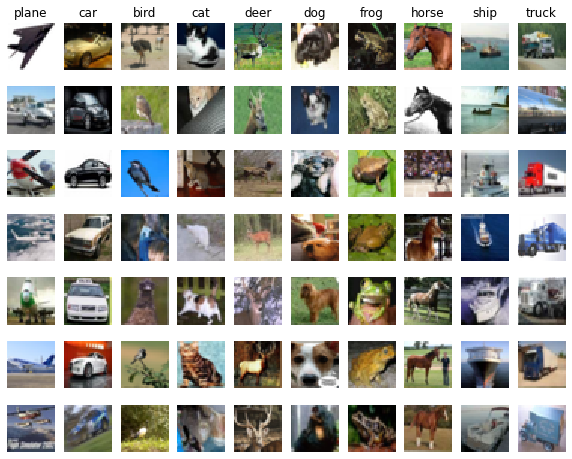

In [12]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


In [13]:
# 划分数据为训练集，验证集，测试集。创建一个小的开发集作为训练集的子集
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 验证集: 验证集来自原本的训练集数据
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# 训练集：
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 开发集：训练集的一个子集
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 测试集
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [14]:
# 数据预处理：把图片数据转换成向量
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# 检查数据的维度
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]
(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


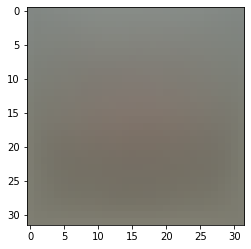

In [15]:
# 预处理：提出图片的均值
# 第一步：计算图片的均值基于整个训练数据
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])  # 前十个图片的均值
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8')) #可视化图片的均值

# 第二步：从训练集和测试集减去图片的均值
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 第三步：附加1的偏置维度（即偏向技巧），以便我们的SVM仅需担心优化单个权重矩阵W。
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

### SVM分类器

In [16]:
from cs231n.classifiers.linear_svm import svm_loss_naive
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.155135


In [17]:

# 计算损失和w的梯度
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)


# 随机选几个维度计算梯度，并且分析梯度， 误差在1e10-6
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 计算梯度带有正则项
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -44.499012 analytic: -44.499012, relative error: 6.792780e-12
numerical: 21.992271 analytic: 21.992271, relative error: 1.008518e-11
numerical: 5.087127 analytic: 5.087127, relative error: 3.378652e-11
numerical: 24.273930 analytic: 24.273930, relative error: 9.777016e-12
numerical: -6.888500 analytic: -6.888500, relative error: 1.633689e-11
numerical: -3.776400 analytic: -3.776400, relative error: 1.421717e-11
numerical: 5.951812 analytic: 5.951812, relative error: 2.726609e-11
numerical: -8.655411 analytic: -8.655411, relative error: 1.596757e-11
numerical: 8.278955 analytic: 8.278955, relative error: 2.015390e-12
numerical: 7.150539 analytic: 7.150539, relative error: 2.617830e-11
numerical: 7.642308 analytic: 7.642308, relative error: 3.983683e-12
numerical: 2.545712 analytic: 2.545712, relative error: 1.069166e-10
numerical: -17.937916 analytic: -17.937916, relative error: 6.936915e-12
numerical: -12.297239 analytic: -12.297239, relative error: 3.309070e-11
numerical: -

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? Hint: the SVM loss function is not strictly speaking differentiable

有时候gradcheck中的维度可能不完全匹配。这种差异是由什么引起的呢？这是值得担忧的原因嘛？在一维中，梯度检查可能失败
的简单例子是什么？提示：SVM的损失函数是不可微的。

$\color{blue}{\textit Your Answer:}$ *当损失函数某些点不可微可能造成这种错误，ReLuf(x)=max(0,x)是不可微的在x=0。根据梯度计算公式$\frac{df(x)}{dx} = \frac{f(x+h) - f(x)}{h}$ , 数值梯度$f'(\frac{h}{2})=\frac{3}{4}$
分析梯度：$f'(x)=1$,这种误差是在x=0附近引起*
$$L = \frac{1}{N} \sum_i \sum_{j\neq y_i} \left[ \max(0, f(x_i; W)_j - f(x_i; W)_{y_i} + \Delta) \right] + \lambda \sum_k\sum_l W_{k,l}^2$$

In [18]:
# 接下来我们实现svm_loss_vectorized
start = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
end  = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, end - start))

from cs231n.classifiers.linear_svm import svm_loss_vectorized

start = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
end  = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_naive, end - start))

# 计算的差是0
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.155135e+00 computed in 0.094037s
Vectorized loss: 9.155135e+00 computed in 0.002944s
difference: -0.000000


In [19]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
# 用L2 norm比较梯度矩阵是否相同
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.097177s
Vectorized loss and gradient: computed in 0.003004s
difference: 0.000000


### 随机梯度下降(Stochastic Gradient Descent)

现在已经向量化的实现了计算损失，梯度。接下来用SGD去最小化损失。code部分重写在cs231n/classifiers/linear_classifier.py.
